# UWMGI-Detectron2 [Training]

## Install Detectron2


In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# importing libraries


In [ ]:
import pandas as pd
import numpy as np
import pandas as pd 
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm # progress bar
from datetime import datetime
import time
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import os, json, cv2, random
import skimage.io as io
import copy
from pathlib import Path
from typing import Optional



from tqdm import tqdm
import itertools

import torch
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from glob import glob
import numba
from numba import jit

import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.


# detectron2
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils


from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

setup_logger()

# Loading Dataset

In [ ]:
Data_Resister_training="uwmgi_train1";
Data_Resister_valid="uwmgi_valid1";
from detectron2.data.datasets import register_coco_instances

dataDir=Path('../input/uw-madison-gi-tract-image-segmentation/')

register_coco_instances(Data_Resister_training,{}, '../input/uwmgi-coco-dataset/coco_train_fold2.json', '')
register_coco_instances(Data_Resister_valid,{},'../input/uwmgi-coco-dataset/coco_valid_fold2.json', '')

metadata = MetadataCatalog.get(Data_Resister_training)
dataset_train = DatasetCatalog.get(Data_Resister_training)
dataset_valid = DatasetCatalog.get(Data_Resister_valid)

# Data Visualization
* It's also very easy to visualize prepared training dataset with detectron2.
* It provides Visualizer class, we can use it to draw an image with mask and bounding box as following.

In [ ]:
fig, ax = plt.subplots(figsize =(15,7))
d=dataset_train[120] 
img = cv2.imread(d["file_name"])
print(img.shape)
v = Visualizer(img[:, :, ::-1],
                metadata=metadata, 
                scale=1.2,
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
out = v.draw_dataset_dict(d)
ax.grid(False)
ax.axis('off')
ax.imshow(out.get_image()[:, :, ::-1])

# LossEvalHook

In [ ]:
import logging
import numpy as np
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime

class LossEvalHook(HookBase):
    def __init__(self, cfg, model, data_loader):
        self._model = model
        self._period = cfg.TEST.EVAL_PERIOD
        self._root = cfg.OUTPUT_DIR
        self._data_loader = data_loader
        self._min_mean_loss = 0.0
        self._bfirst = True
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()
        return mean_loss
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
                
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            mean_loss = self._do_loss_eval()
            if self._bfirst:
                self._min_mean_loss = mean_loss
                self._bfirst = False
            #-------- save best model according to metrics --------
            if mean_loss < self._min_mean_loss:
                self._min_mean_loss = mean_loss
                self.trainer.checkpointer.save('model_best')
                with open('bestiter.txt', 'a+') as f:
                    f.write('min val loss: ' + str(mean_loss) + ' at iter: ' + str(self.trainer.iter) + '\n')

In [ ]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        #return COCOEvaluator(dataset_name,("segm",), True, output_folder)
        #return COCOEvaluator(dataset_name, cfg, True, output_folder)
        return DiceScoreEvaluator(dataset_name)
    
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            self.cfg,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

# Evaluator

In [ ]:
from detectron2.evaluation.evaluator import DatasetEvaluator
import pycocotools.mask as mask_util
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer


def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=0) == 1  # Correct objects
    false_positives = np.sum(matches, axis=1) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=0) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.40, 0.60, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p= 2*tp / (2*tp + fp+fn)
        prec.append(p)
    return np.mean(prec)
        


class DiceScoreEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"Dice Score": np.mean(self.scores)}

# Training

In [ ]:
cfg = get_cfg()
config_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml" 
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = (Data_Resister_training,)
cfg.DATASETS.TEST = (Data_Resister_valid,)

#cfg.MODEL.WEIGHTS ="../input/detectron2cell/output/model_final.pth"

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # 64 is slower but more accurate (128 faster but less accurate)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
cfg.SOLVER.IMS_PER_BATCH = 16 
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

cfg.SOLVER.BASE_LR = 0.002 #(quite high base learning rate but should drop)
cfg.SOLVER.GAMMA = 0.5
    
cfg.SOLVER.WARMUP_ITERS = 10 #How many iterations to go from 0 to reach base LR
cfg.SOLVER.MAX_ITER = 2000 #Maximum of iterations 1
cfg.SOLVER.STEPS = (500, 900, 1200, 1800) #At which point to change the LR 0.25,0.5
cfg.TEST.EVAL_PERIOD = 150
#cfg.SOLVER.CHECKPOINT_PERIOD=250

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)  
trainer.resume_or_load(resume=False)
trainer.train()

# Evaluator

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_best.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor_best = DefaultPredictor(cfg)
evaluator = DiceScoreEvaluator(Data_Resister_valid)
val_loader = build_detection_test_loader(cfg, Data_Resister_valid)
FS_bm=inference_on_dataset(predictor_best.model, val_loader, evaluator)['Dice Score']

In [ ]:
print("Dice Score for best model=",FS_bm)

# Predictor

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold for this model
cfg.DATASETS.TEST = (Data_Resister_valid, )
predictor_final = DefaultPredictor(cfg)
evaluator = DiceScoreEvaluator(Data_Resister_valid)
val_loader = build_detection_test_loader(cfg, Data_Resister_valid)
FS_fm=inference_on_dataset(predictor_final.model, val_loader, evaluator)['Dice Score']

In [ ]:
print("Dice Score for final model=",FS_fm)

In [ ]:
fig, ax = plt.subplots(4, 1, figsize =(20,50))
indices=[ax[0],ax[1],ax[2],ax[3] ]
i=-1
for d in random.sample(dataset_valid, 4):
    i=i+1    
    im = cv2.imread(d["file_name"])
    outputs = predictor_best(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata, 
                   scale=2, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    indices[i].grid(False)
    indices[i].imshow(out.get_image()[:, :, ::-1])

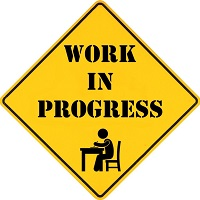